Well, hopefully I will be able to make this work. 

In [1]:
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory, CenterMapFactory
from plastid.plotting.plots import *
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
import csv
from matplotlib.pyplot import figure
from scipy.sparse.linalg import lsqr
from multiprocess import Pool
from tqdm import tqdm

## define functions

In [3]:
def low_density(lamb,a,I = 10):
    '''
    A function that calculates the particle density along a transcript from a set of elongation rates
    inferred from ribosome profiling. This function assumes that elongation is in a low density regime
    (e.g. initiation limiting)
    '''
    Jl = (a*(lamb[0]-a))/(lamb[0] + (I-1)*a)
    pl = 1/(2*I) + (Jl*(I-1))/(2*I*lamb) - np.sqrt((1/(2*I) + (Jl*(I-1))/(2*I*lamb))**2 - Jl/(I*lamb))
    return(pl) 

def high_density(lamb,B,I = 10):
    '''
    A function that calculates the particle density along a transcript from a set of elongation rates
    inferred from ribosome profiling. This function assumes that elongation is in a high density regime
    (e.g. termination limiting)
    '''
    JR = (B*(lamb[-1]-B))/(lamb[-1] + (I-1)*B)
    pR = 1/(2*I) + (JR*(I-1))/(2*I*lamb) + np.sqrt((1/(2*I) + (JR*(I-1))/(2*I*lamb))**2 - JR/(I*lamb))
    return(pR) 

def maximum_current(lamb,a,B,I = 10):
    '''
    A function that calculates the particle density along a transcript from a set of elongation rates
    inferred from ribosome profiling. This function assumes that elongation is in a maximum current regime
    (e.g. elongation limiting)
    '''
    Jmax = min(lamb)/((1+np.sqrt(I))**2)
    flip = np.where(lamb == np.amin(lamb))[0][0]
    pR = 1/(2*I) + (Jmax*(I-1))/(2*I*lamb[0:flip]) + np.sqrt((1/(2*I) + (Jmax*(I-1))/(
        2*I*lamb[0:flip]))**2 - Jmax/(I*lamb[0:flip]))
    pl = 1/(2*I) + (Jmax*(I-1))/(2*I*lamb[flip:]) - np.sqrt((1/(2*I) + (Jmax*(I-1))/(
        2*I*lamb[flip:]))**2 - Jmax/(I*lamb[flip:]))
    p = np.concatenate((pR,pl))
    return(p) 

def make_mc(arr_c, position, a, B, I = 10):
    '''
    This function purposefully induces elongation limitation at a certain point 
    '''
    lamb_c = copy.deepcopy(arr_c)
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    mut_min = position
    while True:
        lamb_c[mut_min] = lamb_c[mut_min]*0.9 # It keeps doing this every run through. 
        Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
        crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
        crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
        if crit_a < a and crit_B < B:
            break
    p = maximum_current(lamb_c,a=a,B=B,I = 10)
    return p

def make_ld(lamb, a, B, I = 10):
    lamb_c = copy.deepcopy(lamb)# Create a copy of lamb to work on. 
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    if a < crit_a and B > crit_B:
        p = low_density(lamb_c, a, I)
    else:
        while True:
            min_l = np.where(lamb_c == np.amin(lamb_c))[0][0]
            lamb_c[min_l] = lamb_c[min_l]*1.1 # It keeps doing this every run through. 
            Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
            crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
            crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
            if a < crit_a and B > crit_B:
                break
        p = low_density(lamb_c, a, I) 
    return p

# I would like to create a function that determines which density function to use, 
# outputs a message saying which one it used, and then calculates the density with the correct function. 

def get_density(lamb, a, B, I = 10):
    lamb_c = copy.deepcopy(lamb)# Create a copy of lamb to work on. 
    Jmax = min(lamb_c)/((1+np.sqrt(I))**2)
    crit_a = ((lamb_c[0] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[0]*Jmax)/((lamb_c[0] - (I - 1)*Jmax)**2)))
    crit_B = ((lamb_c[-1] - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*lamb_c[-1]*Jmax)/((lamb_c[-1] - (I - 1)*Jmax)**2)))
    if a < crit_a and B > crit_B:
        p = low_density(lamb_c, a, I)
        density = "LD"
    elif a > crit_a and B < crit_B:
        p = high_density(lamb_c, B, I)
        density = "HD"
    elif a < crit_a and B < crit_B:
        Jl = (a*(lamb[0]-a))/(lamb[0] + (I-1)*a)
        JR = (B*(lamb[-1]-B))/(lamb[-1] + (I-1)*B)
        sign = Jl - JR 
        if sign > 0:
            p = low_density(lamb_c, a, I)
            density = "LD"
        elif sign < 0:
            p = high_density(lamb_c, B, I)
            density = "HD"
    elif a > crit_a and B > crit_B:
        p = maximum_current(lamb_c, a, B, I)
        density = "MC"
    return p, density

What on earth am I drawing these samples from? I will use my gamma distribution but I should also just try a uniform ditribution like he told me too. 

In [4]:
np.sqrt(5.6)

2.3664319132398464

In [5]:
lamb = np.random.gamma(2.5,3,200)

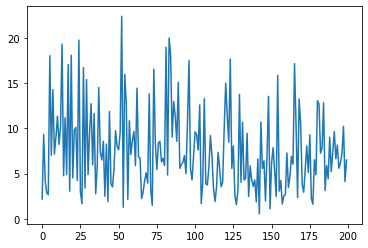

In [6]:
plt.plot(lamb)

In [7]:
p = get_density(lamb, 0.02, 0.1)

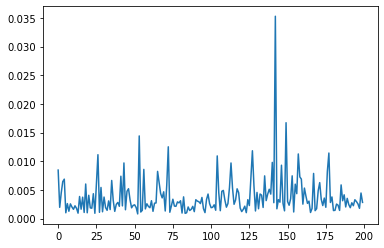

In [8]:
plt.plot(p[0])

In [9]:
x = np.log(lamb)+ np.random.normal(0, 0.1, 200) #must decide on the proper value for the standard deviation, I have no idea if 0.1 is good or not. 
y = math.e**x

## Uniform distribution

In [10]:
lamb_uni = np.random.uniform(0.01,12, 200)

In [11]:
p_uni = get_density(lamb_uni, 0.01, 0.1)

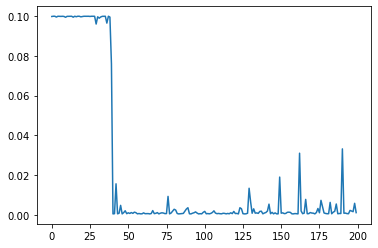

In [17]:
plt.plot(p_uni[0])

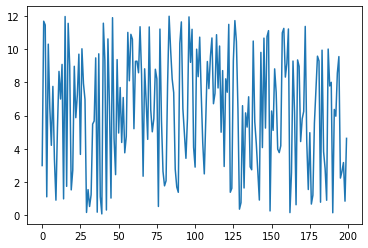

In [18]:
plt.plot(lamb_uni)

## Draw random samples from your particle densities

In [22]:
# Create a function to automate the simulation process
def simulate_reads_LD(mean_lambda, sd, length, a, B, read_density):
    mean_sqr = np.sqrt(mean_lambda)
    sample_size = read_density * length
    lamb = np.random.gamma(mean_sqr, sd, length)
    p = make_ld(lamb, a, B)
    prob = p/sum(p)
    reads = np.zeros(length)
    for i in range(sample_size):
        x = numpy.random.choice(np.arange(0, len(prob)), p = prob)
        reads[x] = reads[x]+1
    return(reads)

def simulate_reads_MC(mean_lambda, sd, length, a, B, read_density, position):
    mean_sqr = np.sqrt(mean_lambda)
    sample_size = read_density * length
    lamb = np.random.gamma(mean_sqr, sd, length)
    p = make_mc(lamb, position, a, B)
    prob = p/sum(p)
    reads = np.zeros(length)
    for i in range(sample_size):
        x = numpy.random.choice(np.arange(0, len(prob)), p = prob)
        reads[x] = reads[x]+1
    return(reads)

def simulate_samples(mean_lambda, sd, length, a, B, read_density, position = None, noise = 0.1, phase = "ld"):
    mean_sqr = np.sqrt(mean_lambda)
    sample_size = int(read_density * length)
    lamb_c = np.random.gamma(mean_sqr, sd, length)
    lamb_m = math.e**(np.log(lamb_c) + np.random.normal(0, noise, length))
    
    # simulate the reads for the control
    p_c = make_ld(lamb_c, a, B)
    prob_c = p_c/sum(p_c)
    reads_c = np.zeros(length)
    for i in range(sample_size):
        x = numpy.random.choice(np.arange(0, len(prob_c)), p = prob_c)
        reads_c[x] = reads_c[x]+1

    # simulate the reads for the mutant assuming LD
    if phase == "ld":
        p_m = make_ld(lamb_m, a, B)
        prob_m = p_m/sum(p_m)
        reads_m = np.zeros(length)
        for i in range(sample_size):
            x = numpy.random.choice(np.arange(0, len(prob_m)), p = prob_m)
            reads_m[x] = reads_m[x]+1
    
    # simulate the reads for the mutant assuming MC
    elif phase == "mc":
        p_m = make_mc(lamb_m, position, a, B)
        prob_m = p_m/sum(p_m)
        reads_m = np.zeros(length)
        for i in range(sample_size):
            x = numpy.random.choice(np.arange(0, len(prob_m)), p = prob_m)
            reads_m[x] = reads_m[x]+1
    return reads_c, reads_m

# Calculate the smoothed density vector pbar for xth entry with length n-9
def get_pbar_from_count(transcript):
    transcript = transcript + 1 #All elongation rates were calculated this way to set a new baseline
    M = sum(transcript)
    p = transcript/M
    x=0
    pbar=[]
    for px in p:
        pbar_x = 0.1*sum(p[x:x+10]) #it is x+10 not x+9 because python does not include the final index.
        pbar.append(pbar_x)
        x = x+1
        if x  == len(p)-9:
            break
    pbar = np.array(pbar)
    return(pbar)

Ok, this works but the function is kind of confusing. Like, if you set the phase to MC only the mutant actually ends up being MC. 

In [23]:
# Create a large number of simulations
# I should probably try to run this in parallel
control_LD = []
mutant_LD = []
for i in range(190):
    length = numpy.random.randint(200,2500)
    x = simulate_samples(5.6, 3, length, 0.01, 0.5, 5, noise = 0.8, phase = "ld")
    control_LD.append(x[0])
    mutant_LD.append(x[1])

In [24]:
control_MC = []
mutant_MC = []
for i in range(10):
    length = numpy.random.randint(200,2500)
    position = numpy.random.randint(10,length/2)
    x = simulate_samples(5.6, 3, length, 0.01, 0.5, 5, position, noise = 0.8, phase = "mc")
    control_MC.append(x[0])
    mutant_MC.append(x[1])


In [25]:
data_control = control_LD + control_MC
data_mutant = mutant_LD + mutant_MC

## Calculate Smoothed Vector Arrays

In [26]:
# Define the maximum number of processors that can be used when creating the smoothed vector arrays
max_pool = 20

# get smoothed vector arrays for all of the control data.
with Pool(max_pool) as p:
    pool_control = list(
         tqdm(
            p.imap(kat.get_smoothed_vector_parallel,
                      data_control),
            total=len(data_control)
        )
    )    

100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 74.69it/s]


In [27]:
# get smoothed vector arrays for all of the mutant data.
with Pool(max_pool) as p:
    pool_mutant = list(
        tqdm(
            p.imap(kat.get_smoothed_vector_parallel,
                       data_mutant),
            total=len(data_mutant)
        )
    )    

100%|█████████████████████████████████████████| 200/200 [00:02<00:00, 74.87it/s]


## Determine KS statistic for all transcripts

In [30]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
ks_list = []
len_list = []
for tr_m, tr_c, index in zip(data_mutant, data_control, list(range(len(data_mutant)))):
    # Only Calculate KS statistics for genes with decent length and read density
     if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.15 and sum(tr_c)/len(tr_c) > 0.15:
        position = np.array(list(range(len(tr_m))))
        smoothed_vec_m, cumul_m = pool_mutant[index]
        smoothed_vec_c, cumul_c = pool_control[index]
        ks = max(abs(cumul_m - cumul_c))
        ks_list.append(ks)
        len_list.append(len(tr_m))
            
# reorganizing the lists into a dataframe. 
df_b = pd.DataFrame(list(zip(ks_list, len_list)))
df_b.columns = ["ks_stat", "gene_length"]
#df_b.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)
    
# Clear out unneeded lists
ks_list.clear()
len_list.clear()

Text(0.5, 1.0, 'KS statistic of all simulated genes')

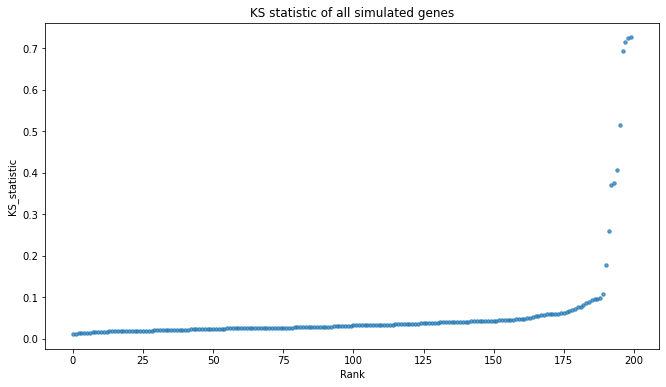

In [31]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (11,6))
plt.scatter(list(range(len(df_b["ks_stat"]))), sorted(df_b["ks_stat"]), s=12, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all simulated genes")

## Notes

Get all of the elongation rates from the gamma distribution, then split them up into the original and the mutant. Add noise to the mutant. take 100 of the mutants and put them through the make MC rather than the make LD.

I must ask Khan what the best way to add noise is. Maybe he has some comment on the right amount of noise to add. 

At the moment I am certainly not seeing something similar to what I am getting with the real data. No matter how much noise I add the KS statistic is always going to be similar since it is applied across all the positions equally on average. Are there other things I should randomize? random initiation and termination rates? randomize mean elongation rate? randomize the read density? Should the initiation rates be systematically different in the mutant or randomly different or not different at all? 

Should I take into account the fact that different particle densities caused by different initiation and elongation rates should inherently lead to different read density? 

## Experimenting with making a phase diagram showing all point. 

In [51]:
a = np.random.normal(1.1, 0.2, 1000)
crit_a = np.random.normal(2.5, 0.2, 1000)
B = np.random.normal(5, 0.5, 1000)
crit_B = np.random.normal(3, 0.5, 1000)

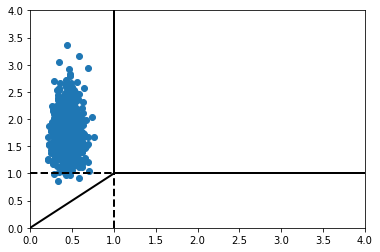

In [60]:
plt.scatter((a/crit_a), (B/crit_B))
plt.ylim([0,4])
plt.xlim([0,4])
plt.plot([1, 1], [1, 10], 'k-', lw=2)
plt.plot([1, 10], [1,1], 'k-', lw = 2)
plt.plot([0, 1], [0,1], 'k-', lw = 2)
plt.plot([0, 1], [1,1], 'k--', lw = 2)
plt.plot([1, 1], [0,1], 'k--', lw = 2)

In [62]:
normal_a = a/crit_a

In [64]:
np.where(normal_a == max(normal_a))[0][0]

833

In [ ]:
def get_critical(l0,lmin,l1):
    Jmax = lmin/((1+np.sqrt(I))**2)
    crit_a = ((lo - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*l0*Jmax)/((l0 - (I - 1)*Jmax)**2)))
    crit_B = ((l1 - (I-1) * Jmax) / 2)*(1 - np.sqrt(1 - (4*l1*Jmax)/((l1 - (I - 1)*Jmax)**2)))
    return 